#### 보스턴 집값 예측 모델
* 데이터 셋 : boston.csv
* 목적 : MEDV 예측
* 피쳐 : 13개
* 학습방법 : 지도학습 > 회귀
* 알고리즘 : nn.Linear

In [32]:
# 모듈 로딩
import torch                    # 텐서 및 수치 계산 함수 관련 모듈
import torch.nn.functional as F # 손길, 거리 등 함수 관련 모듈
import pandas as pd             
import torch.nn as nn           # 인공신경망 관련 모듈
import torch.optim as optimizer # 최적화 기법 관련 모듈
from torchmetrics.regression import R2Score
from torchinfo import summary
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [33]:
# 데이터 로딩
file_name = r'C:\VSCode\KDT\Torch_DL\Data\boston_prices.csv'
bostonDF = pd.read_csv(file_name)
bostonDF

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273,21.0,393.45,6.48,22.0


In [34]:
# 랜덤 시드 설정
torch.manual_seed(7)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE => {DEVICE}')

DEVICE => cpu


In [35]:
# 데이터 확인
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


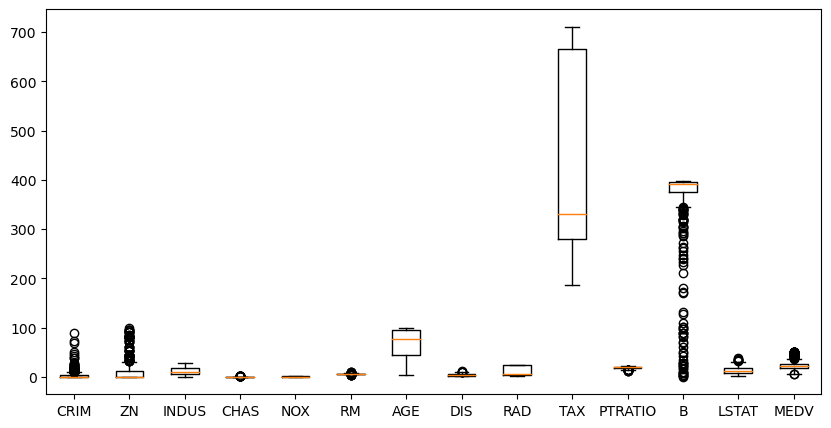

In [36]:
# 박스플롯으로 데이터 확인
plt.figure(figsize=(10,5))
plt.boxplot(bostonDF.iloc[:,:14])
plt.xticks(np.arange(1,15),bostonDF.columns[:14])
plt.show()

# 컬럼들간에 값의 차이가 있으므로 스케일링이 필요해보임.

In [73]:
featureDF = bostonDF[bostonDF.columns[:-1]]
targetSR = bostonDF[['MEDV']]

print(f'feature : {featureDF.shape}, target : {targetSR.shape}')

feature : (506, 13), target : (506, 1)


In [86]:
# 데이터셋 분리
X_train,X_test,y_train,y_test = train_test_split(featureDF,
                                                 targetSR,
                                                 random_state=77,
                                                 test_size=0.2)

X_train,X_val,y_train,y_val = train_test_split(X_train,
                                                 y_train,
                                                 random_state=77,
                                                 test_size=0.2)

print(f'[Feature] Train {X_train.shape}, TEST { X_test.shape}, VAL {X_val.shape}')
print(f'[Target] Train {y_train.shape}, TEST { y_test.shape}, VAL {y_val.shape}')


[Feature] Train (323, 13), TEST (102, 13), VAL (81, 13)
[Target] Train (323, 1), TEST (102, 1), VAL (81, 1)


In [98]:
# 스케일링
Scale = StandardScaler()
Scale.fit(X_train)

X_Scaled_train = Scale.transform(X_train)
X_train_scaled_df = pd.DataFrame(X_Scaled_train, columns=X_train.columns)
X_Scaled_test = Scale.transform(X_test)
X_test_scaled_df = pd.DataFrame(X_Scaled_test, columns=X_test.columns)
X_Scaled_val = Scale.transform(X_val)
X_val_scaled_df = pd.DataFrame(X_Scaled_val, columns=X_val.columns)

In [99]:
# 모델 인스턴스 호출
model = nn.Sequential(nn.Linear(13,27),
                      nn.ReLU(),
                      nn.Linear(27,30),
                      nn.ReLU(),
                      nn.Linear(30,10),
                      nn.ReLU(),
                      nn.Linear(10,1))

In [100]:
# 모델 메모리 확인
print(model)
summary(model,input_size=(506,13))

Sequential(
  (0): Linear(in_features=13, out_features=27, bias=True)
  (1): ReLU()
  (2): Linear(in_features=27, out_features=30, bias=True)
  (3): ReLU()
  (4): Linear(in_features=30, out_features=10, bias=True)
  (5): ReLU()
  (6): Linear(in_features=10, out_features=1, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [506, 1]                  --
├─Linear: 1-1                            [506, 27]                 378
├─ReLU: 1-2                              [506, 27]                 --
├─Linear: 1-3                            [506, 30]                 840
├─ReLU: 1-4                              [506, 30]                 --
├─Linear: 1-5                            [506, 10]                 310
├─ReLU: 1-6                              [506, 10]                 --
├─Linear: 1-7                            [506, 1]                  11
Total params: 1,539
Trainable params: 1,539
Non-trainable params: 0
Total mult-adds (M): 0.78
Input size (MB): 0.03
Forward/backward pass size (MB): 0.28
Params size (MB): 0.01
Estimated Total Size (MB): 0.31

In [101]:
# 가중치와 절편 확인
for name, param in model.named_parameters():
    print(f'[{name}] {param}\n')

[0.weight] Parameter containing:
tensor([[-0.1633,  0.2155,  0.1754,  0.2217,  0.2244, -0.1085, -0.0934, -0.1995,
         -0.1279,  0.1047, -0.0251,  0.2572,  0.0036],
        [ 0.2735, -0.0348, -0.0568,  0.2228, -0.0690,  0.0559, -0.1769, -0.1092,
          0.0085,  0.2368, -0.2359,  0.0594,  0.1879],
        [ 0.1691, -0.2514,  0.0811, -0.2308, -0.0635,  0.0710, -0.2433, -0.2447,
          0.0990, -0.2702, -0.0745, -0.2699, -0.2266],
        [ 0.2140, -0.0499, -0.1057,  0.1113, -0.0282, -0.0978,  0.0145, -0.1824,
          0.1080, -0.2137,  0.0477, -0.2285, -0.1402],
        [ 0.0987,  0.1610,  0.2702,  0.1235, -0.1399, -0.1170,  0.1589, -0.0517,
         -0.0990,  0.0030,  0.1910,  0.1158,  0.2121],
        [-0.0761,  0.0947, -0.1327,  0.0506,  0.2768,  0.2079,  0.1657,  0.0584,
         -0.2386,  0.1530,  0.2505,  0.0086, -0.1540],
        [ 0.0018, -0.2285,  0.0155, -0.2083,  0.0681, -0.1998, -0.0743,  0.1417,
         -0.1757,  0.0427,  0.2573,  0.0823, -0.0169],
        [-0.213

In [102]:
## 모델의 가중치와 절편을 최적화 ==> 인스턴스에 전달
adam_opt=optimizer.Adam(model.parameters(), lr=0.1)

In [103]:
# 학습 진행
# - 에포크 => 학습횟수
# - loss => 학습결과(손실저장)

EPOCH = 100
BATCH_SIZE = 10
BATCH_CNT = X_train.shape[0]//BATCH_SIZE
print(f'EPOCH:{EPOCH}, BATCH_SIZE:{BATCH_SIZE}, BATCH_CNT:{BATCH_CNT}')

EPOCH:100, BATCH_SIZE:10, BATCH_CNT:32


In [104]:
def testing(testDF,targetDF, kind='Val'):
    # Tensor화
    testTS=torch.FloatTensor(testDF.values).to(DEVICE)
    targetTS=torch.FloatTensor(targetDF.values).to(DEVICE)
    with torch.no_grad(): # 가중치 및 절편 업데이트 진행 X
        # (1) 학습진행
        pre_y=model(testTS)
        #-(2)오차계산 - 손실함수
        loss=F.mse_loss(pre_y, targetTS)

        #-(3)성능평가 - R2
        r2 = R2Score()(pre_y, targetTS)
 
        #-(4)학습결과 출력 및 저장
        #print(f'[{kind}] LOSS: {loss}, R2 : {r2}')
    return loss, r2

In [105]:
# 모델 학습 함수
def training(featureTS, targetTS, valTS, valTargetTS, testTS, testtargetTS):

    loss_history=[[],[],[]] # [[트레인], [검증], [테스트]]
    r2_hisory =[[],[],[]] # [[트레인], [검증], [테스트]]

    for epoch in range(EPOCH):
        # 배치 손실 저장 변수
        bs_loss, bs_r2 = 0,0
        # 배치 크기 만큼 학습 진행
        for i in range(BATCH_CNT):
            start = i*BATCH_SIZE  
            end = start + BATCH_SIZE
            # BS 크기만큼만의 데이터를 추출해서 Tensor화 진행
            BSX_train = torch.FloatTensor(X_train[start:end].values).to(DEVICE) # 배치의 트레인 피쳐
            BSy_train = torch.FloatTensor(y_train[start:end].values).to(DEVICE) # 배치의 트레인 정답


            #-(1)학습진행 - forward
            pre_y=model(BSX_train)
            #-(2)오차계산 - 손실함수
            loss=F.mse_loss(pre_y, BSy_train)
            bs_loss += loss.item()
            r2 =R2Score()(pre_y, BSy_train)
            bs_r2 += r2.item()
        
            #-(3)최적화 - 가중치,절편 업데이트 backward
            adam_opt.zero_grad() #gradient를 0으로 초기화
            loss.backward() #  오차 미분, 비용 함수를 미분하여 gradient 계산
            adam_opt.step() #  가중치 업데이트 W와 b를 업데이트

        #-(4)검증 - 모댈이 제대로 만들어지는 검사용
        val_loss, val_r2 = testing(valTS, valTargetTS)
        loss_history[1].append(val_loss.item())
        r2_hisory[1].append(val_r2.item())
        
        # (5) 에포크 단위 손실과 성능지표
        loss_history[0].append(bs_loss/BATCH_CNT) # 평균을 추가
        r2_hisory[0].append(bs_r2/BATCH_CNT)   # 평균을 추가

        #-(5)테스트 - 테스트 결과 저장
        test_loss, test_r2 = testing(testTS, testtargetTS)
        loss_history[2].append(test_loss.item())
        r2_hisory[2].append(test_r2.item())

        #-(6)학습결과 출력 및 저장
        print(f'[{epoch}//{EPOCH}]\n Train LOSS: {loss_history[0][-1]} R2 : {r2_hisory[0][-1]}')
        print(f'-VALID LOSS: {loss_history[1][-1]} R2 : {r2_hisory[1][-1]}')
        print(f'-TEST LOSS: {loss_history[2][-1]} R2 : {r2_hisory[2][-1]}')
    return loss_history, r2_hisory

In [106]:
# 모델 학습 진행
loss, r2 = training(X_train_scaled_df, y_train, X_val_scaled_df, y_val, X_test_scaled_df, y_test)

[0//100]
 Train LOSS: 2270.872548162937 R2 : -59.285461235791445
-VALID LOSS: 293.1507263183594 R2 : -2.6965413093566895
-TEST LOSS: 235.4185791015625 R2 : -2.395514726638794
[1//100]
 Train LOSS: 86.91982191801071 R2 : -0.19988943822681904
-VALID LOSS: 326.12176513671875 R2 : -3.1122961044311523
-TEST LOSS: 264.7452087402344 R2 : -2.8185017108917236
[2//100]
 Train LOSS: 79.15500926971436 R2 : -0.030927103012800217
-VALID LOSS: 252.53311157226562 R2 : -2.1843655109405518
-TEST LOSS: 199.46249389648438 R2 : -1.876908779144287
[3//100]
 Train LOSS: 73.07393443584442 R2 : 0.03472112491726875
-VALID LOSS: 194.7762908935547 R2 : -1.4560697078704834
-TEST LOSS: 148.3908233642578 R2 : -1.1402864456176758
[4//100]
 Train LOSS: 67.38619220256805 R2 : 0.06084517203271389
-VALID LOSS: 124.70698547363281 R2 : -0.5725170373916626
-TEST LOSS: 91.19894409179688 R2 : -0.3153904676437378
[5//100]
 Train LOSS: 50.495910584926605 R2 : 0.351729329675436
-VALID LOSS: 88.95963287353516 R2 : -0.121753811836

In [107]:
loss

[[2270.872548162937,
  86.91982191801071,
  79.15500926971436,
  73.07393443584442,
  67.38619220256805,
  50.495910584926605,
  71.52057194709778,
  63.43401649594307,
  47.95335096120834,
  39.97140100598335,
  40.45735344290733,
  55.70574426651001,
  38.89065270125866,
  36.25566524267197,
  33.81730632483959,
  34.000128626823425,
  35.44760890305042,
  38.11889939010143,
  41.89514797925949,
  36.79116716980934,
  39.20727361738682,
  37.679180920124054,
  31.392243802547455,
  33.076486974954605,
  31.593888700008392,
  35.545143127441406,
  36.807045847177505,
  33.75666218996048,
  30.583122804760933,
  37.265305265784264,
  35.3249406516552,
  31.293448388576508,
  32.42481470108032,
  31.068890780210495,
  30.36400532722473,
  31.99325244128704,
  32.30671638250351,
  31.479546144604683,
  29.008907161653042,
  30.985240265727043,
  32.88882955908775,
  33.57513901591301,
  29.322090461850166,
  34.68382157385349,
  33.251510977745056,
  31.08883509039879,
  33.2895748913288

In [108]:
testing(X_test, y_test)

(tensor(71.0430), tensor(-0.0247))

Text(0.5, 1.0, 'r2')

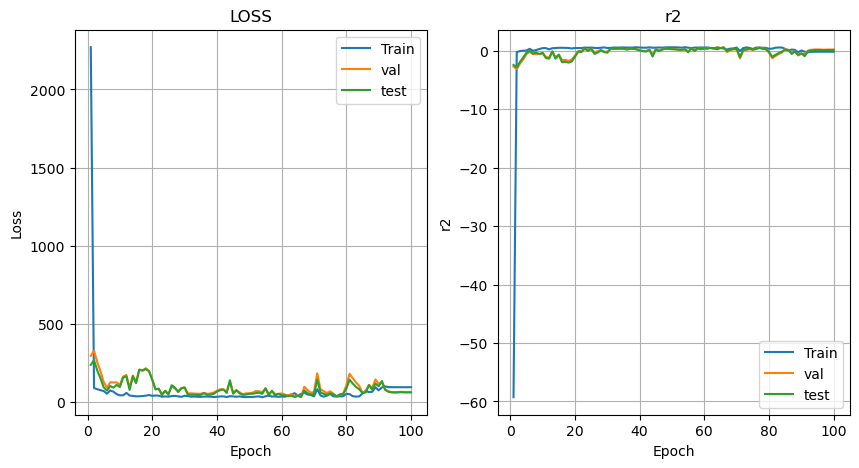

In [110]:
# 시각화

fg, axes = plt.subplots(1,2 , figsize=(10,5))
axes[0].plot(range(1, EPOCH+1), loss[0], label='Train')
axes[0].plot(range(1, EPOCH+1), loss[1], label='val')
axes[0].plot(range(1, EPOCH+1), loss[2], label='test')
axes[0].grid()
axes[0].legend()
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("LOSS")

axes[1].plot(range(1, EPOCH+1), r2[0], label='Train')
axes[1].plot(range(1, EPOCH+1), r2[1], label='val')
axes[1].plot(range(1, EPOCH+1), r2[2], label='test')
axes[1].grid()
axes[1].legend()
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("r2")
axes[1].set_title("r2")
